## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Моисеенков Павел Сергеевич

In [23]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
import train_utils
import sys

%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

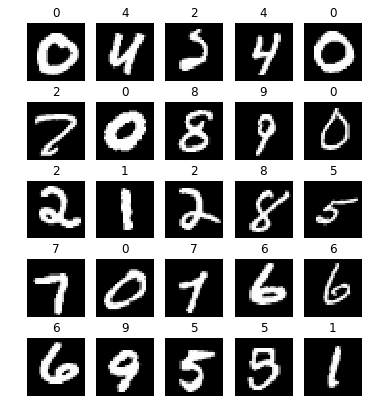

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print ('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print ('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def linear_layer(input_size, output_size, init_layer):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer)
    return layer

In [8]:
##### YOUR CODE HERE #####
def check(init_layer, fun_activ):
    layers = []
    layers.append(linear_layer(784, 500, init_layer))
    layers.append(fun_activ())
    for i in range(10):
        layers.append(linear_layer(500, 500, init_layer))
        layers.append(fun_activ())
    layers.append(linear_layer(500, 10, init_layer))
    layers.append(nn.LogSoftmax())
    network = nn.Sequential(*layers)
    
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

In [9]:
check(init_layer, nn.Tanh)

forward 0.9978966116905212
forward 0.9858282208442688
forward 0.9822289347648621
forward 0.9813321828842163
forward 0.9819333553314209
forward 0.9815880060195923
forward 0.98145991563797
forward 0.9815537333488464
forward 0.9816747307777405
forward 0.9823094606399536
forward 0.9818854331970215
forward 0.9817808866500854
backward 0.04693586006760597
backward 0.01976822502911091
backward 0.06651084870100021
backward 0.22592559456825256
backward 0.7416676878929138
backward 2.803682327270508
backward 9.584976196289062
backward 33.71000289916992
backward 109.37309265136719
backward 373.3084716796875
backward 1275.000732421875
backward 3610.703125


/Users/P_Moiseenkov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
##### YOUR CODE HERE #####
def init_layer_Xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    a = np.sqrt(6) / np.sqrt(weight.shape[0] + weight.shape[1])
    weight.uniform_(-a, a)
    
def init_layer_He(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2/weight.shape[1]))

*** Инициализация He функции ReLU ***

In [11]:
check(init_layer_He, nn.ReLU)

forward 0.9978966116905212
forward 0.848590075969696
forward 0.8374809622764587
forward 0.8588176965713501
forward 0.892982542514801
forward 0.8869364857673645
forward 0.88432377576828
forward 0.9071650505065918
forward 0.9103460311889648
forward 0.9064121246337891
forward 0.8392431139945984
forward 0.8213917016983032
backward 0.1907747983932495
backward 0.023606009781360626
backward 0.0223239678889513
backward 0.02223583124577999
backward 0.021484222263097763
backward 0.019212543964385986
backward 0.018268009647727013
backward 0.016114449128508568
backward 0.014928988181054592
backward 0.013556198216974735
backward 0.012355653569102287
backward 0.01052248664200306


/Users/P_Moiseenkov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


*** Инициализация He функции Tanh ***

In [12]:
check(init_layer_He, nn.Tanh)

forward 0.9978966116905212
forward 0.7150704264640808
forward 0.632654070854187
forward 0.5918183922767639
forward 0.5784235000610352
forward 0.5657026767730713
forward 0.5623368620872498
forward 0.5581471920013428
forward 0.5547260046005249
forward 0.5533266663551331
forward 0.5591574311256409
forward 0.5573223233222961
backward 0.054081931710243225
backward 0.007783269975334406
backward 0.00784862507134676
backward 0.007927787490189075
backward 0.008479454554617405
backward 0.00830775685608387
backward 0.007880250923335552
backward 0.008159786462783813
backward 0.00800445768982172
backward 0.00822699349373579
backward 0.008225478231906891
backward 0.0066466559655964375


/Users/P_Moiseenkov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


***Инициализация Xavier функции ReLU***

In [13]:
check(init_layer_Xavier, nn.ReLU)

forward 0.9978966116905212
forward 0.6644534468650818
forward 0.46853840351104736
forward 0.32974207401275635
forward 0.23867221176624298
forward 0.17310389876365662
forward 0.12821057438850403
forward 0.09226778894662857
forward 0.0709746703505516
forward 0.05015696957707405
forward 0.03702593967318535
forward 0.02499536983668804
backward 0.03635792061686516
backward 0.005189067684113979
backward 0.0037556409370154142
backward 0.0027247630059719086
backward 0.001949021709151566
backward 0.001458080718293786
backward 0.0009589460096322
backward 0.0006603139918297529
backward 0.00045918498653918505
backward 0.0003358761896379292
backward 0.0002291904529556632
backward 0.0001591347245266661


/Users/P_Moiseenkov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


***Инициализация Xavier функции Tanh***

In [14]:
check(init_layer_Xavier, nn.Tanh)

forward 0.9978966116905212
forward 0.6455363631248474
forward 0.49058297276496887
forward 0.4121430516242981
forward 0.355319619178772
forward 0.316849023103714
forward 0.29231539368629456
forward 0.2709360420703888
forward 0.2524428963661194
forward 0.23824891448020935
forward 0.227727472782135
forward 0.21193233132362366
backward 0.04276016354560852
backward 0.007554624695330858
backward 0.007355690002441406
backward 0.007212856784462929
backward 0.006652378011494875
backward 0.006129602435976267
backward 0.005873719230294228
backward 0.00543627655133605
backward 0.004886476788669825
backward 0.004090467002242804
backward 0.0031414423137903214
backward 0.002105269581079483


/Users/P_Moiseenkov/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [25]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.025/0.090	Accuracy: 0.992/0.974


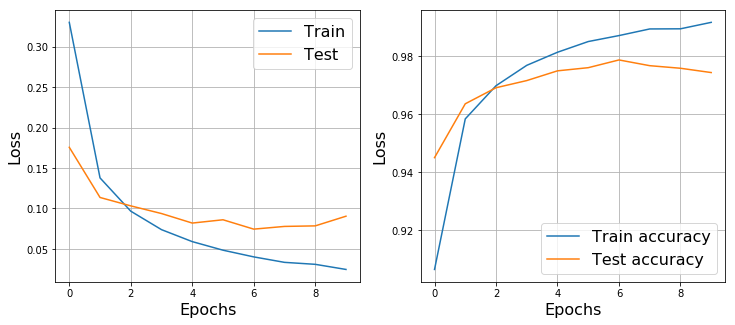

In [26]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

In [27]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+self.p
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

Epoch 9... (Train/Test) NLL: 0.121/0.134	Accuracy: 0.961/0.960


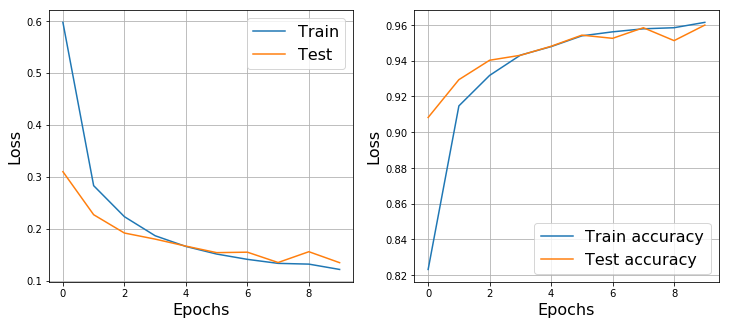

In [28]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 40... (Train/Test) NLL: 0.083/0.164	Accuracy: 0.974/0.964


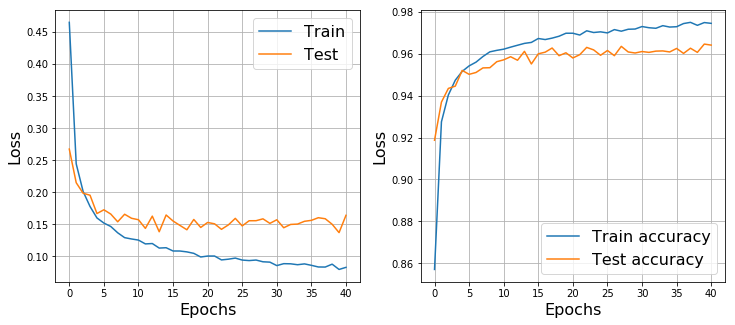

In [29]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 50, 0.001)

In [ ]:
##### YOUR CODE HERE #####

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [30]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if x.shape[0] != 1:
            output = (x - mean) / std ##### YOUR CODE HERE #####
            return output
        else:
            return x

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.025/0.091	Accuracy: 0.992/0.975


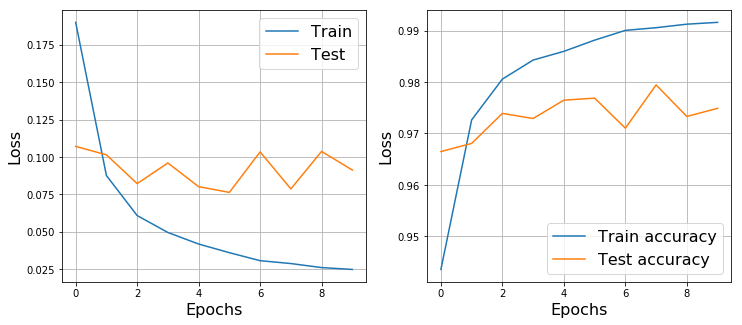

In [31]:
##### YOUR CODE HERE #####
network = nn.Sequential(nn.Linear(28*28, 200), 
                        nn.BatchNorm1d(num_features=200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(num_features=200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 1e-2)

Epoch 9... (Train/Test) NLL: 0.031/0.073	Accuracy: 0.989/0.978


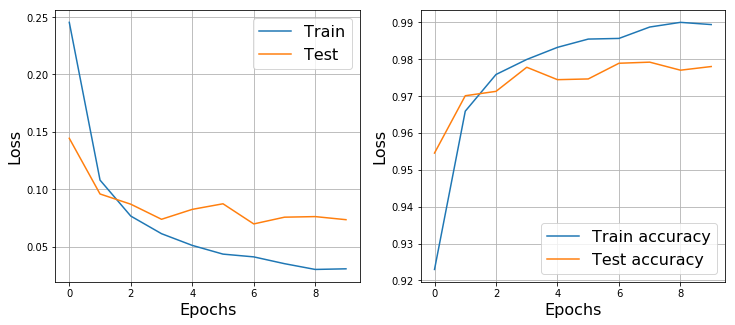

In [32]:
##### YOUR CODE HERE #####
network = nn.Sequential(nn.Linear(28*28, 200), 
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 1e-2)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: